In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, LeakyReLU, Reshape

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mnist = tf.keras.datasets.mnist
(X, y), (X_test, y_test) = mnist.load_data()
X, X_test = X / 255 * 2 - 1, X_test / 255.0 * 2 - 1

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X = X.reshape(-1, 28, 28, 1)

In [4]:
def get_generator (latent_space):
    
    i = Input(shape=(latent_space,))
        
    x = Dense(256,activation=LeakyReLU(alpha=0.2)) (i)
    x = BatchNormalization(momentum=0.7) (x)
    x = Dropout (0.2) (x)
    
    x = Dense(512,activation=LeakyReLU(alpha=0.2)) (x)
    x = BatchNormalization(momentum=0.7) (x)
    x = Dropout (0.2) (x)

    x = Dense(1024, activation='tanh') (x)

    x = Reshape ((32, 32, 1)) (x)
    
    x = Conv2D (16, (3, 3), activation=LeakyReLU(alpha=0.2)) (x)
    x = Conv2D (1, (3, 3), activation='tanh') (x)

    model = Model(i, x)
    
    return model

In [5]:
def get_discriminator (img_shape):
    
    i = Input(shape=img_shape)
    
    x = Conv2D (6, (3, 3), activation=LeakyReLU(alpha=0.2)) (i)
    x = Flatten ()(x)
    x = Dense (128, activation=LeakyReLU(alpha=0.2)) (x)
    x = BatchNormalization(momentum=0.7) (x)
    x = Dropout (0.3)(x)
    x = Dense (1, activation='sigmoid') (x)

    model = Model (i, x)
    
    return model

In [6]:
latent_space = 100
img_shape = (28, 28, 1)
generator = get_generator(latent_space)
discriminator = get_discriminator(img_shape)

In [7]:
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

In [8]:
def get_gan (latent_space):

    discriminator.trainable = False
    
    inputs = Input (shape=latent_space)
    img = generator(inputs)
    pred_d = discriminator(img)

    model = Model (inputs, pred_d)
    return model

In [9]:
gan = get_gan (latent_space)

gan.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

In [10]:
batch_size = 32
epochs = 30000
period = 1000

In [11]:
def save_img (epoch):
    noise = np.random.randn(batch_size, 100)
    imgs = generator.predict(noise)

    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(3, 3)
    idx = 0
    for i in range(3):
        for j in range(3):
            axs[i,j].imshow(imgs[idx].reshape(28, 28), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("/kaggle/working/%d.png" % epoch)
    plt.close()

In [12]:
d_acc_list = []
g_acc_list = []
d_loss_list = []
g_loss_list = []

In [13]:
for epoch in range(epochs):

    noise = np.random.randn(batch_size//2, 100)

    x_false, false = generator.predict(noise), np.zeros(batch_size//2)
    
    idx = np.random.randint(0, X.shape[0], batch_size//2)
    x_true, true = X[idx], np.ones(batch_size//2)

    x_final = np.concatenate((x_false, x_true))
    label = np.concatenate((false, true))
    
    d_loss, d_acc = discriminator.train_on_batch(x_final, label)
    
    noise = np.random.randn(batch_size, 100)
    g_loss, g_acc = gan.train_on_batch(noise, np.ones(batch_size))    
    
    noise = np.random.randn(batch_size, 100)
    g_loss, g_acc = gan.train_on_batch(noise, np.ones(batch_size))
    
    d_acc_list.append (d_acc)
    g_acc_list.append (g_acc)
    d_loss_list.append (d_loss)
    g_loss_list.append (g_loss)
    print ('d_acc : ', d_acc,'g_acc : ', g_acc, 'd_loss : ', d_loss, 'g_loss : ', g_loss)
    
    if epoch % period == 0:
        save_img (epoch)

1/1 [==============================] - 9s 9s/step
d_acc :  0.21875 g_acc :  0.75 d_loss :  1.30849289894104 g_loss :  0.6519417762756348
1/1 [==============================] - 0s 18ms/step
d_acc :  0.875 g_acc :  0.8125 d_loss :  0.31694191694259644 g_loss :  0.6577252149581909
1/1 [==============================] - 0s 17ms/step
d_acc :  0.96875 g_acc :  0.4375 d_loss :  0.13158099353313446 g_loss :  0.7087898254394531
1/1 [==============================] - 0s 19ms/step
d_acc :  1.0 g_acc :  0.09375 d_loss :  0.04878987371921539 g_loss :  0.8316670656204224
1/1 [==============================] - 0s 19ms/step
d_acc :  1.0 g_acc :  0.03125 d_loss :  0.03761329874396324 g_loss :  0.9806380271911621
1/1 [==============================] - 0s 18ms/step
d_acc :  1.0 g_acc :  0.0 d_loss :  0.03259018063545227 g_loss :  1.1920645236968994
1/1 [==============================] - 0s 19ms/step
d_acc :  1.0 g_acc :  0.0 d_loss :  0.01387027744203806 g_loss :  1.45415198802948
1/1 [==================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 19ms/step
d_acc :  0.71875 g_acc :  0.21875 d_loss :  0.551931619644165 g_loss :  1.1840007305145264
1/1 [==============================] - 0s 26ms/step
d_acc :  0.71875 g_acc :  0.28125 d_loss :  0.4977770149707794 g_loss :  1.142590045928955
1/1 [==============================] - 0s 21ms/step
d_acc :  0.6875 g_acc :  0.34375 d_loss :  0.4799101650714874 g_loss :  1.0527230501174927
1/1 [==============================] - 0s 21ms/step
d_acc :  0.78125 g_acc :  0.03125 d_loss :  0.5253121852874756 g_loss :  1.6664974689483643
1/1 [==============================] - 0s 18ms/step
d_acc :  0.78125 g_acc :  0.09375 d_loss :  0.4993046224117279 g_loss :  1.3724396228790283
1/1 [==============================] - 0s 18ms/step
d_acc :  0.59375 g_acc :  0.0 d_loss :  0.7387803196907043 g_loss :  1.6470177173614502
1/1 [==============================] - 0s 18ms/step
d_acc :  0.5625 g_acc :  0.09375 d_loss :  0.6345837116241455 g_loss :  1.6932387351989746


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



d_acc :  0.71875 g_acc :  0.25 d_loss :  0.5956820249557495 g_loss :  1.164215326309204
1/1 [==============================] - 0s 18ms/step
d_acc :  0.6875 g_acc :  0.34375 d_loss :  0.6163843870162964 g_loss :  1.0064759254455566
1/1 [==============================] - 0s 18ms/step
d_acc :  0.71875 g_acc :  0.09375 d_loss :  0.6174329519271851 g_loss :  1.3756482601165771
1/1 [==============================] - 0s 18ms/step
d_acc :  0.65625 g_acc :  0.1875 d_loss :  0.5494968891143799 g_loss :  1.3031542301177979
1/1 [==============================] - 0s 18ms/step
d_acc :  0.6875 g_acc :  0.0625 d_loss :  0.6180462837219238 g_loss :  1.6315466165542603
1/1 [==============================] - 0s 18ms/step
d_acc :  0.625 g_acc :  0.1875 d_loss :  0.723013162612915 g_loss :  1.387453317642212
1/1 [==============================] - 0s 17ms/step
d_acc :  0.625 g_acc :  0.375 d_loss :  0.5955040454864502 g_loss :  0.9494353532791138
1/1 [==============================] - 0s 19ms/step
d_acc :  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 18ms/step
d_acc :  0.8125 g_acc :  0.3125 d_loss :  0.49968037009239197 g_loss :  1.0899310111999512
1/1 [==============================] - 0s 18ms/step
d_acc :  0.71875 g_acc :  0.34375 d_loss :  0.5570047497749329 g_loss :  1.0263569355010986
1/1 [==============================] - 0s 18ms/step
d_acc :  0.6875 g_acc :  0.28125 d_loss :  0.576934814453125 g_loss :  1.1894521713256836
1/1 [==============================] - 0s 19ms/step
d_acc :  0.6875 g_acc :  0.09375 d_loss :  0.6949865221977234 g_loss :  1.366030216217041
1/1 [==============================] - 0s 17ms/step
d_acc :  0.75 g_acc :  0.1875 d_loss :  0.4636043310165405 g_loss :  1.5915882587432861
1/1 [==============================] - 0s 18ms/step
d_acc :  0.71875 g_acc :  0.15625 d_loss :  0.7095869779586792 g_loss :  1.3728611469268799
1/1 [==============================] - 0s 22ms/step
d_acc :  0.75 g_acc :  0.03125 d_loss :  0.490911602973938 g_loss :  1.6134905815124512
1/1 [

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 18ms/step
d_acc :  0.625 g_acc :  0.3125 d_loss :  0.5892440676689148 g_loss :  1.0203180313110352
1/1 [==============================] - 0s 18ms/step
d_acc :  0.59375 g_acc :  0.5 d_loss :  0.5426781177520752 g_loss :  0.9106164574623108
1/1 [==============================] - 0s 19ms/step
d_acc :  0.625 g_acc :  0.5 d_loss :  0.7377452850341797 g_loss :  0.9134624004364014
1/1 [==============================] - 0s 17ms/step
d_acc :  0.78125 g_acc :  0.3125 d_loss :  0.5475209951400757 g_loss :  0.9783987998962402
1/1 [==============================] - 0s 18ms/step
d_acc :  0.75 g_acc :  0.28125 d_loss :  0.453458309173584 g_loss :  1.0491359233856201
1/1 [==============================] - 0s 18ms/step
d_acc :  0.625 g_acc :  0.21875 d_loss :  0.5629369020462036 g_loss :  1.145427942276001
1/1 [==============================] - 0s 19ms/step
d_acc :  0.625 g_acc :  0.1875 d_loss :  0.6603578925132751 g_loss :  1.4464038610458374
1/1 [===========

AttributeError: 'list' object has no attribute 'shape'

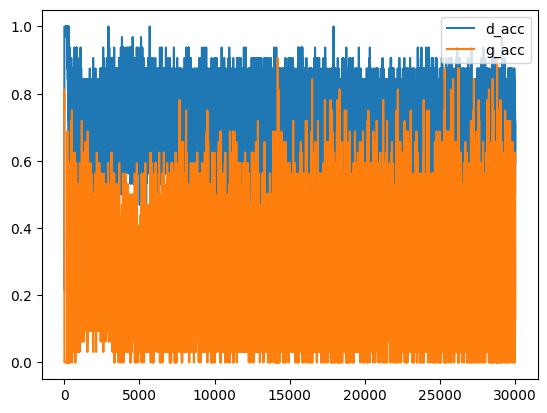

In [18]:
plt.plot(d_acc_list, label='d_acc')
plt.plot(g_acc_list, label='g_acc')
plt.legend()

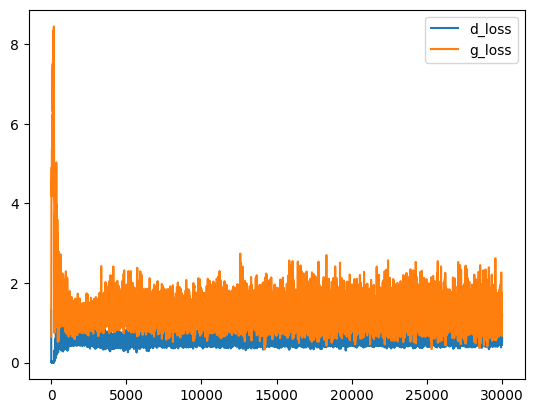

In [19]:
plt.plot(d_loss_list, label='d_loss')
plt.plot(g_loss_list, label='g_loss')
plt.legend()